# IHT.jl tutorial (brief)

In this tutorial we explore some of the functionality of the IHT.jl package, which implements iterative hard threhsolding on floating point arrays and binary PLINK data. 

The first part of the tutorial demonstrates how to handle floating point data. Later we will show how to use [PLINK binary genotype files](http://pngu.mgh.harvard.edu/~purcell/plink/binary.shtml). IHT.jl offers two parallel computational frameworks for PLINK data: multicore CPUs or massively parallel GPUs. Although this tutorial features the CPU version, instructions for GPU use are included.

IHT performs penalized least squares regression. In regression settings with more predictors than cases, IHT chooses a parsimonious sparse statistical model of a user-specified size.

This tutorial targets novice users. Advanced users are encouraged to read the full tutorial located at `~/.julia/v0.4/IHT/IHT_tutorial_full.ipynb`.

We begin by adding processors and loading libraries. Here we use the internal Julia variable `CPU_CORES` to enlist all available CPU cores for our calculations.

In [1]:
addprocs(CPU_CORES) # important for parallel crossvalidation
using IHT, PLINK    # load libraries; IHT.jl performs analysis, PLINK.jl handles PLINK files

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /Users/kkeys/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /Users/kkeys/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /Users/kkeys/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /Users/kkeys/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /Users/kkeys/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /Users/kkeys/.julia/v0.4/DataArr

For this tutorial, we will use a script to simulate all data and variables. The script is located at `simpath`:

In [2]:
simpath = expanduser("~/.julia/v0.4/IHT/sim/tutorial_simulation.jl")
include(simpath)

Simulation complete.


The script `tutorial_simulation.jl` generates a floating point data matrix `X` with a response vector `y`. The vector `y` is simulated from a sparse statistical model $\boldsymbol{\beta}$ with $k_{\text{true}} = 10$ nonzero coefficients. In practice, users will probably load data from file using the commands

    X = readdlm(PATH_TO_X.txt)      # load data X
    y = vec(readdlm(PATH_TO_Y.txt)) # `readdlm` returns a matrix; we apply `vec` to "vec"torize y 

The Julia function `readdlm` **read**s **d**e**l**i**m**ited files such as CSV or tab-delimited TXT into a matrix. It offers several optional keyword arguments to correctly handle the variety of possible delimited files. Two important ones are `header` and `delim`. If the delimited file includes a header, then users should call

    X, h = readdlm(PATH_TO_X_WITH_HEADER.txt, header=true) # array h contains the header names

The argument `delim` specifies the text **delim**iter. The default delimiter is whitespace, though `delim` accepts any suitable ASCII character as a delimiter. If data are stored in CSV, then we can use `readdlm` or just `readcsv`:

    X = readdlm(PATH_TO_X.csv, ',') # read delimited file with comma delimiter
    X = readcsv(PATH_TO_X.csv)      # syntactic sugar for previous command

With our data `X` in hand, we now run iterative hard thresholding to capture the best model of size `k = 10`. The function call is `L0_reg`, which returns an object `output` with the following fields:

- `output.time`, the compute time in seconds
- `output.iter`, the number of iterations taken until convergence
- `output.loss`, the residual sum of squares at convergence
- `output.beta`, the $\boldsymbol{\beta}$ vector at convergence

In [3]:
output = L0_reg(X,y,k)  # run IHT with data X, response y, and desired model size k = 10


Compute time (sec):   1.174987156
Final loss:           25.12432779234657
Iterations:           13
IHT estimated a vector of type Array{Float64,1} with 10 nonzeroes.
10×2 DataFrames.DataFrame
│ Row │ Predictor │ β         │
├─────┼───────────┼───────────┤
│ 1   │ 3310      │ -0.346533 │
│ 2   │ 4460      │ 0.612489  │
│ 3   │ 5861      │ 0.175425  │
│ 4   │ 9731      │ -0.494717 │
│ 5   │ 11294     │ 1.36302   │
│ 6   │ 11378     │ -0.588894 │
│ 7   │ 14217     │ 0.154568  │
│ 8   │ 15118     │ 0.0318823 │
│ 9   │ 19815     │ 0.374349  │
│ 10  │ 23295     │ -1.38392  │

Let us compare the results against the true model `β`:

In [4]:
using DataFrames                            # use this for pretty printing
bk = copy(output.beta)                      # estimated coefficients for use in DataFrame for pretty print
DataFrame(True=β[bidx], Estimated=bk[bidx]) # compare true β to estimated coefficients; bidx indexes true model

,True,Estimated
1,-0.3415878605106918,-0.3465328047275522
2,0.612106578026074,0.6124888053512004
3,0.17464993473691912,0.1754252654651017
4,-0.49442336754995897,-0.49471735856772536
5,1.36305572329991,1.3630163562939566
6,-0.5884901765760026,-0.5888940203365721
7,0.15592390435786463,0.15456839075560397
8,0.031168027119253712,0.03188229647020043
9,0.37405638155560583,0.37434943029627643
10,-1.381677681609053,-1.3839150267818134


We see that IHT returns all the correct nonzero coefficients. The coefficient values themselves are fairly close to their originals. We expect this since the noise level of the simulated data `s = 0.1` does not yield a very noisy `y`. Observe what happens when we use a noisier response `y2` simulated from the same data `X`:

In [5]:
output2 = L0_reg(X, y2, k)                                    # run IHT with noisier response y2
bk2     = copy(output2.beta)                                  # copy results for later use
DataFrame(True=β[bidx], Noisy=bk[bidx], Noisier=bk2[bidx])    # compare analysis of y, y2 against truth

,True,Noisy,Noisier
1,-0.3415878605106918,-0.3465328047275522,-0.32664440171179165
2,0.612106578026074,0.6124888053512004,0.6043578016287964
3,0.17464993473691912,0.1754252654651017,0.0
4,-0.49442336754995897,-0.49471735856772536,-0.6128985166245167
5,1.36305572329991,1.3630163562939566,1.39415276816263
6,-0.5884901765760026,-0.5888940203365721,-0.6134708956260445
7,0.15592390435786463,0.15456839075560397,0.0
8,0.031168027119253712,0.03188229647020043,0.0
9,0.37405638155560583,0.37434943029627643,0.0
10,-1.381677681609053,-1.3839150267818134,-1.3305914662126284


The coefficient values for the noiser response `y2` are markedly less accurate, and several nonzero values are not recovered. Note that a failure to recover the correct model does not indicate that IHT model selection performance is necessarily bad; the high noise level makes accurate estimation of the model quite difficult.

## IHT for GWAS

IHT.jl interfaces with [PLINK.jl](https://github.com/klkeys/PLINK.jl) for GWAS analysis. PLINK.jl primarily handles PLINK binary genotype files (BED files), but also requires the corresponding BIM and FAM files to be in the same directory. In this section of the tutorial we will demonstrate GWAS analysis with IHT.jl. For the purpose of the tutorial, we will use simulated binary genotype from PLINK.jl.

Our binary genotype data are housed in `xbed` and the corresponding simulated response is `ybed`. To instead load genotype data from the file stored at `xpath`, we use the command

    x = BEDFile(xpath)

This command will initialize `x` from binary genotype file. It adds an intercept by default.
To include nongenetic covariates stored at `covpath`, then the Julia call is

    x = BEDFile(xpath, covpath)

Here the intercept is **not** added by default, as PLINK.jl assumes that it is stored in `covpath`.
PLINK.jl expects that `covpath` points to a delimited text file and uses `readdlm` to load the covariates. Consequently, the previous discussion about delimited files applies. We could load covariates from a delimited file with a header by calling

    x = BEDFile(xpath, covpath, header=true)
    
Note that IHT **does not** work with categorical covariates! All covariates must either be numerical or quantitative dummy variables. Furthermore, IHT **WILL NOT** work with missing data! Any missing genotypes or covariates must be suitably imputed before running IHT.

For analysis with PLINK files, the call to `L0_reg` is the same as with the floating point `X`. 

In [6]:
output = L0_reg(xbed, ybed, k) # run IHT with BED files


Compute time (sec):   7.647730133
Final loss:           25.07111852912545
Iterations:           13
IHT estimated a vector of type Array{Float64,1} with 10 nonzeroes.
10×2 DataFrames.DataFrame
│ Row │ Predictor │ β         │
├─────┼───────────┼───────────┤
│ 1   │ 650       │ -0.179789 │
│ 2   │ 3288      │ 1.80377   │
│ 3   │ 6035      │ 0.137861  │
│ 4   │ 6931      │ -0.854269 │
│ 5   │ 7949      │ 1.02445   │
│ 6   │ 8886      │ 0.0930143 │
│ 7   │ 14799     │ -0.439589 │
│ 8   │ 14984     │ -1.46272  │
│ 9   │ 19620     │ 0.705692  │
│ 10  │ 19872     │ 0.0107966 │

As before, let us compare the estimated model to the simulated one:

In [7]:
bk3 = copy(output.beta)                            # copy the beta for later use
DataFrame(β=bbed[bidxbed], Estimated=bk3[bidxbed]) # did we get the correct model and coefficient values?

,β,Estimated
1,-0.17662234765522025,-0.17978884776848136
2,1.8033550620219114,1.8037736382537508
3,0.13537685603482832,0.13786081979821607
4,-0.8555703671688936,-0.8542691347151112
5,1.021995923569984,1.0244477084069694
6,0.09032685911384171,0.09301432688497134
7,-0.4422339870333382,-0.43958897755397247
8,-1.4639844854590376,-1.462718672970754
9,0.7051108026937771,0.7056920632053494
10,0.0109636974011309,0.010796628253813265


## Crossvalidation with numeric data

These exploratory efforts are admittedly not illuminating. In a realistic setting, we wouldn't know the correct model size $k_{\text{true}}$. IHT handles this by crossvalidating the best model size $k_{\text{best}}$ with the function `cv_iht`. Let us compute $k_{\text{best}}$ for the very noisy response `y2`:

In [8]:
srand(2016) # reset seed before crossvalidation for reproducible results
cv_output = cv_iht(X, y2)

An IHTCrossvalidationResults object with the following results:
Minimum MSE 16.161813213014682 occurs at k = 6.
Best model β has the following nonzero coefficients:
6×2 DataFrames.DataFrame
│ Row │ Predictor │ β         │
├─────┼───────────┼───────────┤
│ 1   │ 3310      │ -0.33289  │
│ 2   │ 4460      │ 0.615219  │
│ 3   │ 9731      │ -0.60089  │
│ 4   │ 11294     │ 1.40044   │
│ 5   │ 11378     │ -0.613623 │
│ 6   │ 23295     │ -1.35266  │


IHT calculates an ideal model size $k_{\text{best}} = 6$ that is smaller than the true model size $k_{\text{true}} = 10$, again highlighting the negative effects of noise on our ability to correctly estimate the correct statistical model.

The function `cv_iht` guesses (hopefully) reasonable defaults for the fold structure, the models to test, and the desired number of crossvalidation folds. Users can modify these with the following optional keyword arguments:

- `q` is the number of folds to compute. The default is always greater than 2, and is usually 5. An error is thrown if `q <= 2`.
- `path` is an integer vector of model sizes to test. The default is to test sizes $1, 2, \ldots, 20$.
- `folds` is an integer vector that assigns data to each fold. The default is to randomly assign data as evenly as possible to each fold.

IHT provides a `plot` function to generate a simple line plot of mean squared errors (MSEs) versus model size from crossvalidation results:

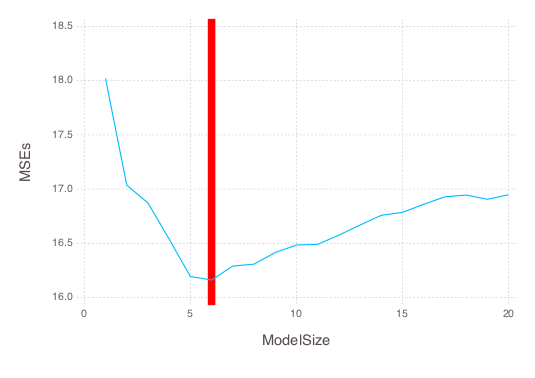

In [9]:
IHT.plot(cv_output)

This default plotting function adds a red line at $k_{\text{best}}$. Users who wish to generate their own plots and are comfortable with the Julia command line have several options available to them. Some notable ones include:

- [Gadfly.jl](http://gadflyjl.org/) (IHT uses Gadfly for plotting)
- [Plots.jl](https://juliaplots.github.io/)
- [PyPlot.jl](https://github.com/stevengj/PyPlot.jl)

Alternatively, users can write the MSEs and model sizes to file and then load them in their favorite plotting environment, such as [R](https://www.r-project.org/). One simple way to save MSEs and model sizes is to call `readdlm`'s companion function `writedlm`:

    writedlm(PATH_TO_NEW_FILE.txt, [x.path x.mses]) # creates the matrix [x.path x.mses] and saves it to file

## Crossvalidation with genotype data

IHT.jl can use PLINK files directly in parallel crossvalidation. However, the interface of `cv_iht` changes in two crucial ways. Firstly, instead of feeding the data `X` and `y` directly, we must point `cv_iht` to the locations of all data files stored on disk. Secondly, all data except the covariates must be stored in *binary* format.

Storing data in binary format is actually quite simple. The call in Julia is `write`. For example, the script `tutorial_simulation.jl` saved the response variable `ybed` to the desktop in binary format by calling

    ypath     = expanduser("~/Desktop/y.bin") # path to save response ybed to desktop
    write(open(ypath, "w"), ybed)             # "w"rite ybed to file
 
The script also generated the correct filepaths to simulated genotype data stored the PLINK.jl module. Now let us run the crossvalidation routine with binary data:

In [10]:
srand(2016) # reset seed before crossvalidation to make reproducible results
cv_bed  = cv_iht(xpath, covpath, ypath)

An IHTCrossvalidationResults object with the following results:
Minimum MSE 0.006067673766979373 occurs at k = 10.
Best model β has the following nonzero coefficients:
10×2 DataFrames.DataFrame
│ Row │ Predictor │ β         │
├─────┼───────────┼───────────┤
│ 1   │ 650       │ -0.179729 │
│ 2   │ 3288      │ 1.804     │
│ 3   │ 6035      │ 0.137926  │
│ 4   │ 6931      │ -0.854346 │
│ 5   │ 7949      │ 1.02459   │
│ 6   │ 8886      │ 0.0930185 │
│ 7   │ 14799     │ -0.439675 │
│ 8   │ 14984     │ -1.46289  │
│ 9   │ 19620     │ 0.705787  │
│ 10  │ 19872     │ 0.0109802 │


Here we see that IHT finds the correct model size $k_{\text{true}} = 10$. We can verify that IHT also captures the correct predictors and provides reasonably accurate estimates of the coefficients:

In [11]:
DataFrame(βidx=bidxbed, cv_idx=cv_bed.bidx, # compare the indices of the nonzeroes...
βcoeff=bbed[bidxbed], cv_coeff=cv_bed.b)    # ... and compare the coefficients.

,βidx,cv_idx,βcoeff,cv_coeff
1,650,650,-0.17662234765522025,-0.17972917415173537
2,3288,3288,1.8033550620219114,1.803996069296465
3,6035,6035,0.13537685603482832,0.1379260826149328
4,6931,6931,-0.8555703671688936,-0.8543457712216785
5,7949,7949,1.021995923569984,1.0245908186860375
6,8886,8886,0.09032685911384171,0.09301854809645414
7,14799,14799,-0.4422339870333382,-0.43967455805102
8,14984,14984,-1.4639844854590376,-1.4628859276639845
9,19620,19620,0.7051108026937771,0.7057872847521028
10,19872,19872,0.0109636974011309,0.010980233843360372


We can also plot MSEs versus model size:

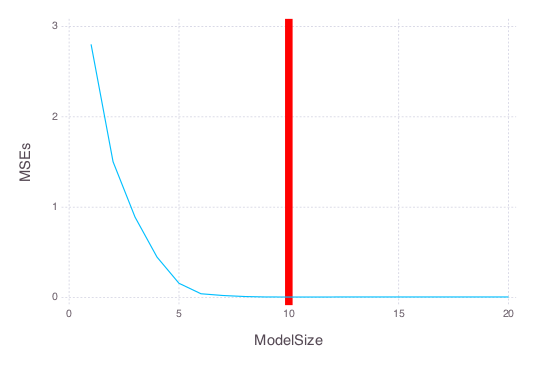

In [12]:
IHT.plot(cv_bed)

Before we close this section on crossvalidation, we must remove the simulated GWAS response located at `ypath = ~/Desktop/y.bin`:

In [13]:
rm(ypath)

## GPUs

As mentioned before, IHT.jl can use GPUs to accelerate computations. This is an advanced topic, so we will only outline its use. We will not execute any code here since we cannot assume that the user has a dedicated GPU on their machine.

Using GPUs with IHT.jl require both a `BEDFile` object and a string object containing the GPU code. PLINK.jl preloads the requisite GPU code into the variable `PLINK.gpucode64`. Assuming that a suitable GPU device is available on the machine, one can call `L0_reg` with GPU facilities using

    output = L0_reg(xbed, ybed, k, PLINK.gpucode64)

Using GPUs in crossvalidation merely entails adding `PLINK.gpucode64` as an argument to `cv_iht`:

    cv_bed = cv_iht(xpath, covpath, ypath, PLINK.gpucode64)

## References 

We hope that this tutorial is useful. Interested readers can consult the following references for further study:

- Kevin L. Keys, Gary K. Chen, Kenneth Lange. (2016) *Iterative Hard Thresholding for Model Selection in Genome-Wide Association Studies*. [(arXiv)](http://arxiv.org/abs/1608.01398)
- Thomas Blumensath and Mike E. Davies. (2010) "Normalized Iterative Hard Thresholding: Guaranteed Stability and Performance". *IEEE Journal of Selected Topics in Signal Processing* **4**:2, 298-309. [(pdf)](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5419091) [(preprint)](http://www.personal.soton.ac.uk/tb1m08/papers/BD_NIHT09.pdf)
- Thomas Blumensath and Mike E. Davies. (2009) "Iterative Hard Thresholding for Compressed Sensing". *Applied and Computational Harmonic Analysis* **27**:3, 265-274. [(pdf)](http://www.sciencedirect.com/science/article/pii/S1063520309000384) [(arXiv)](http://arxiv.org/abs/0805.0510)